In [3]:
import torch
import torch.nn.functional as F

torch.__version__

'2.1.1+cu121'

In [14]:
class Linear:
    def __init__(self, in_features, out_features, bias=True, dtype=None):
        self.gain = torch.randn(
            (in_features, out_features), dtype=dtype)
        self.bias = torch.randn(
            out_features, dtype=dtype) if bias else None

    def __call__(self, input: torch.Tensor):
        out = input @ self.gain
        if self.bias is not None:
            out += self.bias
        return out

    def parameters(self):
        return [self.gain] + ([] if self.bias is None else [self.bias])

Linear(5, 3)(torch.randn(50, 5)).shape

torch.Size([50, 3])


In [16]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

Tanh()(torch.randn(50, 5)).max()

tensor(0.9988)

In [37]:

class BatchNorm:
    """
    One-Dimensional Batch Normalization
    """

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers (not trained with backprop)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def parameters(self):
        return [self.gamma, self.beta]

    def __call__(self, x):
        if self.training:
            mean = x.mean(dim=0)
            var = x.var(dim=0)
            x_hat = (x - mean) / (var + self.eps).sqrt()
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * \
                    self.running_mean + self.momentum * mean
                self.running_var = (1 - self.momentum) * \
                    self.running_var + self.momentum * var
        else:
            x_hat = (x - self.running_mean) / \
                    (self.running_var + self.eps).sqrt()

        return self.gamma * x_hat + self.beta

dist = BatchNorm(5)(torch.randn(50, 5))
# this is a gaussiana find the mean and variance
mean = dist.mean(dim=0).abs().min().item()
std = dist.std(dim=0).mean().item()
mean, std

(0.0, 0.9999939203262329)

In [149]:
g = torch.Generator().manual_seed(123)
max_steps = 5000
emb_size = 50
hl_size = 100  # hidden layer size
ctx_len = 5
vocab_size = 10
# same optimization as last time
batch_size = 32
losses = []
ud = []
lre = torch.linspace(-4, 0, max_steps)
lri = 10 ** lre

# X = torch.randint(0, vocab_size, (1000, ctx_len), generator=g)
# X = torch.rand((1000, ctx_len), generator=g) * vocab_size
# X = X.floor().long()
# Y = torch.randint(0, vocab_size, (1000,), generator=g)

# X = torch.arange(0, 100).unsqueeze(1) + torch.arange(ctx_len)
# Y = torch.arange(0, 100)
# vocab_size = torch.unique(X).shape[0]

X = torch.ones(1000, ctx_len, dtype=torch.long)
Y = torch.ones(1000, dtype=torch.long) * 8

C = torch.randn((vocab_size, emb_size), dtype=torch.float32, generator=g)

layers = [
    Linear(emb_size * ctx_len, hl_size,
            bias=False), BatchNorm(hl_size), Tanh(),
    Linear(hl_size, hl_size, bias=False), BatchNorm(hl_size), Tanh(),
    Linear(hl_size, vocab_size, bias=False), BatchNorm(vocab_size),
]

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters), len(parameters))

for p in parameters:
    p.requires_grad = True

X.shape, Y.shape, C.shape, X[0]

36920 10


(torch.Size([1000, 5]),
 torch.Size([1000]),
 torch.Size([10, 50]),
 tensor([1, 1, 1, 1, 1]))

step 0, loss 2.30
step 1000, loss 2.05
step 2000, loss 0.92
step 3000, loss 0.09
step 4000, loss 0.01
accuracy 1.00


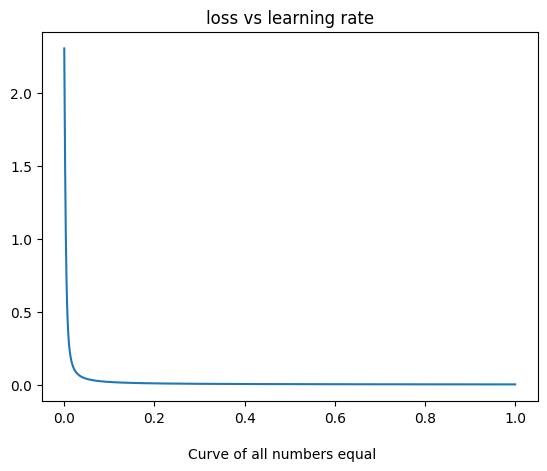

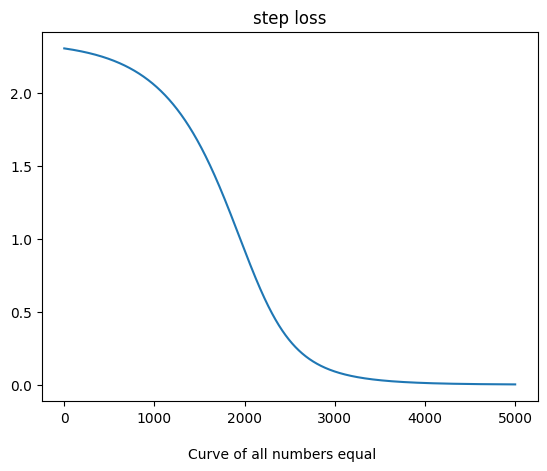

In [150]:
for i in range(max_steps):
    # minibatch
    # use all
    ix = torch.arange(X.shape[1])
    # ix = torch.randint(0, X.shape[0], (batch_size*8,))
    #forward
    emb = C[X]
    x = emb.view(emb.shape[0], -1)

    for layer in layers:
        x = layer(x)

    logits = x
    loss = F.cross_entropy(logits, Y)

    # backward
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    with torch.no_grad():
        for p in parameters:
            p -= lri[i] * p.grad

    losses.append(loss.item())

    if i % 1000 == 0:
        print(f"step {i}, loss {loss.item():.2f}")

import matplotlib.pyplot as plt
import os

os.makedirs("./research/", exist_ok=True)
with torch.no_grad():
    emb = C[X]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    logits = x
    pred = logits.argmax(dim=1)
    acc = (pred == Y).float().mean().item()
    print(f"accuracy {acc:.2f}")

with torch.no_grad():
    plt.title("loss vs learning rate")
    plt.figtext(0.5, 0,"Curve of all numbers equal", ha='center', va='center', fontsize=10)
    plt.plot(lri, losses)
    plt.savefig(os.path.join("research","equal_loss_vs_lr.png"))
    plt.show()

    plt.title("step loss")
    plt.figtext(0.5, 0,"Curve of all numbers equal", ha='center', va='center', fontsize=10)
    plt.plot(losses)
    plt.savefig(os.path.join("research","equal_random_step_loss.png"))
    plt.show()


